In [25]:
# --- STRATEGIC PROJECT MANAGEMENT: EXECUTIVE SUMMARY ---

# This analysis uses AI to provide **data-driven instructions** for your highest-risk projects.

# 1. The Core Prediction:
# The model identifies strategic transformation projects with the highest **Go-Live Risk Probability**.

# 2. The Recommended Action:
# For these risky projects, the AI calculates a conservative **P80 reserve** (80th percentile risk) for both money and time.
# * **Money Reserve:** Set aside the maximum recommended **Contingency** (e.g., 25% of budget) to cover predicted financial overruns.
# * **Time Reserve:** Add a substantial **Schedule Buffer** (e.g., +50% of the predicted delay) to protect the final Time-to-Market date.

# 3. Strategic Transformation Insight:
# The current fixed limit (e.g., 25% cap) is **too rigid** and forces all high-risk projects to look the same.
# **To implement strategic transformation,** executive leadership must transition from rigid rules to **contextual reserves**:
# * **Tailor the Caps:** The maximum reserve should be flexible (e.g., 35% for Core System Migrations vs. 15% for Digital Product Launches).
# * **Prioritize Time:** For regulatory projects, the strategic focus must shift to ensuring the **Time Buffer Cap** is adequate, as the cost of non-compliance outweighs budget overruns.

In [ ]:
# Minimal working example (synthetic data → models → metrics → explainability)
# --- Setup
import numpy as np, pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')
rng = np.random.default_rng(42)


# --- 2.1 
# --- Setup (ensure necessary imports are present) ---
import numpy as np
import pandas as pd
# Assume rng = np.random.default_rng(42) has been defined
# from earlier setup steps in the notebook.
  
# --- Adapted Data Generation Block ---
N = 2000 # Number of synthetic projects
df = pd.DataFrame({
    # Financial Scale: Log-normal distribution for typical project budgets (in Millions GBP)
    "Approved_Budget_MM": rng.lognormal(mean=3.5, sigma=1.0, size=N),
    
    # Project Domain Complexity (Categorical)
    "Regulatory_Domain": rng.choice(
        ["CoreSystem_Migration", "AML_Compliance", "Digital_Product_Launch", "Risk_Data_Warehousing"],
        N, p=[.25, .25, .25, .25]
    ),
    
    # Contractual Risk: How the project is sourced (Categorical)
    "Sourcing_Model": rng.choice(
        ["Fixed_Price_Vendor", "Time_and_Materials", "Internal_Agile", "Hybrid_Managed"], 
        N, p=[.35, .25, .20, .20]
    ),
    
    # Internal Organization/Region (Categorical)
    "Business_Unit": rng.choice(["Retail_Banking", "Investment_Mgmt", "Wealth_Advisory", "Risk_Compliance"], N),
    
    # Upstream Quality: Clarity of requirements at project start (Numeric)
    "Requirements_Clarity_Score": rng.uniform(40, 100, N),
    
    # Scope Creep: Volume of formal change requests (Count)
    "CR_Volume": rng.poisson(5, N), 
    
    # Delivery Quality: Past performance of the delivery team/vendor (Numeric)
    "Team_Experience_Score": rng.normal(75, 10, N).clip(40, 100),
    
    # Economic/Resource Pressure: Volatility in external resource costs (Index)
    "Consultant_Rate_Index": rng.normal(1.0, 0.08, N).clip(0.8, 1.3),
    
    # Economic/Resource Pressure: Volatility in internal talent availability (Rate)
    "Talent_Attrition_Rate": rng.normal(0.10, 0.05, N).clip(0.01, 0.25),
    
    # Schedule Factor: Internal lead time for security/compliance sign-offs (Days)
    "IT_Security_Lead_Days": rng.integers(10, 60, N),
    
    # Schedule Factor: Rate of missed dependencies from external projects (Fraction)
    "Interdependency_Fail_Rate": rng.beta(2, 8, N),
    
    # Quality Issue: Volume of clarification requests from delivery to business (Count)
    "Ambiguity_Query_Volume": rng.poisson(25, N),
    
    # Quality Issue: Defects found in User Acceptance Testing (Fraction)
    "UAT_Defect_Density": rng.beta(2, 20, N),
    
    # Financial Factor: Initial budget buffer allocated (Percentage)
    "Budgeted_Contingency_Pct": rng.uniform(5, 15, N),
    
    # Time Factor: Available slack time in the critical path (Days)
    "Schedule_Buffer_Days": rng.integers(0, 60, N),
    
    # Complexity: Difficulty of compliance or stakeholder alignment (Ordinal)
    "Regulatory_Complexity_Score": rng.choice([1,2,3,4,5], N, p=[.1,.25,.3,.25,.1]),
    
    # Time Factor: Project start month mapped to business cycles (Integer)
    "Quarter_Start_Month": rng.choice([1, 4, 7, 10], N), 
})

display(df.head())

,Approved_Budget_MM,Regulatory_Domain,Sourcing_Model,Business_Unit,Requirements_Clarity_Score,CR_Volume,Team_Experience_Score,Consultant_Rate_Index,Talent_Attrition_Rate,IT_Security_Lead_Days,Interdependency_Fail_Rate,Ambiguity_Query_Volume,UAT_Defect_Density,Budgeted_Contingency_Pct,Schedule_Buffer_Days,Regulatory_Complexity_Score,Quarter_Start_Month
0,44.912542,CoreSystem_Migration,Fixed_Price_Vendor,Investment_Mgmt,97.740712,4,72.136458,1.086316,0.056087,48,0.061200,29,0.018147,11.065962,23,4,4
1,11.704998,AML_Compliance,Fixed_Price_Vendor,Investment_Mgmt,62.915133,8,83.304809,0.929298,0.191674,26,0.189302,25,0.139290,10.068113,38,4,7
2,70.137051,Digital_Product_Launch,Fixed_Price_Vendor,Risk_Compliance,59.547492,8,82.101625,0.963581,0.051785,55,0.313378,27,0.055610,5.422415,45,2,7
3,84.822829,CoreSystem_Migration,Time_and_Materials,Investment_Mgmt,70.600635,6,80.416692,0.948238,0.048570,35,0.463759,34,0.073059,13.207590,28,1,7
4,4.706595,AML_Compliance,Internal_Agile,Wealth_Advisory,57.501285,3,74.757191,1.040814,0.049718,53,0.053738,21,0.155581,14.867497,38,3,10


In [15]:
# Latent drivers for Budget Variance (formerly base_overrun)
# This models factors driving an increase in the final project budget variance.
base_budget_variance = (
    0.02 # Base administrative/inefficiency cost (2%)
    + 0.3*(df["Consultant_Rate_Index"]-1) # High consultant rate index pushes budget up
    + 0.25*(df["Talent_Attrition_Rate"]-0.1) # High attrition rate pushes budget up (e.g., replacement/hiring costs)
    + 0.006*df["UAT_Defect_Density"]*100 # High defect density (rework) adds cost
    + 0.003*df["CR_Volume"] # High change request volume adds cost
    + 0.0006*(180 - df["Requirements_Clarity_Score"]) # Low requirements clarity adds cost/ambiguity buffer
    + 0.002*(df["Regulatory_Complexity_Score"]-3) # High regulatory complexity adds cost
    - 0.002*(df["Team_Experience_Score"]-75)/10 # High team experience reduces cost
    - 0.002*(df["Budgeted_Contingency_Pct"]-10) # High budgeted contingency reduces reported variance
)

# Latent drivers for Time-to-Market Delay (formerly base_slip)
# This models factors driving delays in the project timeline.
base_delay_days = (
    5 # Baseline internal coordination delay (5 days)
    + 0.6*df["Interdependency_Fail_Rate"]*100 # High external interdependency failure rate adds delay
    + 0.15*df["Ambiguity_Query_Volume"] # High ambiguity query volume adds delay
    + 0.08*df["CR_Volume"] # High change request volume adds delay
    + 0.12*(df["Regulatory_Complexity_Score"]-3)*10 # High regulatory complexity adds delay
    - 0.25*df["Schedule_Buffer_Days"] # Schedule buffer reduces delay
    - 0.10*(df["Team_Experience_Score"]-75)/2 # High team experience reduces delay
    + 0.05*(180 - df["IT_Security_Lead_Days"])  # Shorter internal security lead time indicates rushed pre-work, leading to later delays
)

# Generate random noise
noise_budget = rng.normal(0, 0.04, N)
noise_delay = rng.normal(0, 12, N)

# Final Target Generation with Noise and Clipping (Adapted Target Names)
df["Budget_Variance_Pct"] = (base_budget_variance + noise_budget).clip(-0.05, 0.6)
df["Time_to_Market_Delay_Days"] = (base_delay_days + noise_delay).clip(-20, 180)

# Go-Live Risk Flag (1 = High Risk)
# Flag if Budget Variance > 10% OR Delay > 30 days
df["Go_Live_At_Risk_Flag"] = ((df["Budget_Variance_Pct"] > 0.10) | (df["Time_to_Market_Delay_Days"] > 30)).astype(int)


# --- 2.2 Train/validation split Setup (Adapted) ---

# Define the new Finance target variables
target_budget = "Budget_Variance_Pct"
target_delay = "Time_to_Market_Delay_Days"
target_golive_risk = "Go_Live_At_Risk_Flag"

# Extract the target variables (the y-variables)
y_budget = df[target_budget]
y_delay = df[target_delay]
y_golive_risk  = df[target_golive_risk]

# Create the Feature Matrix (X) by dropping the target columns
X = df.drop(columns=[target_budget, target_delay, target_golive_risk])

# Identify Feature Types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing Pipelines
numeric = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
])
categorical = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric, num_cols),
        ("cat", categorical, cat_cols)
    ]
)

In [16]:
# --- 2.3 Models (Adapted for Finance)
# Budget Variance Model (Regression)
reg_budget = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

# Time-to-Market Delay Model (Regression)
reg_delay = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

# Go-Live Risk Classification Model (Classification)
clf_golive_risk = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestClassifier(n_estimators=600, class_weight="balanced", random_state=42, n_jobs=-1))
])

# Assuming target variables were renamed in section 2.2 as:
# y_budget (formerly y_cost), y_delay (formerly y_time), y_golive_risk (formerly y_cls)

# Data Splitting
X_train, X_test, y_budget_tr, y_budget_te, y_delay_tr, y_delay_te, y_golive_risk_tr, y_golive_risk_te = train_test_split(
X, y_budget, y_delay, y_golive_risk, test_size=0.25, random_state=42
)

# Model Fitting
reg_budget.fit(X_train, y_budget_tr)
reg_delay.fit(X_train, y_delay_tr)
clf_golive_risk.fit(X_train, y_golive_risk_tr)

# --- 2.4 Evaluation (Adapted Metrics)
pred_budget = reg_budget.predict(X_test)
pred_delay = reg_delay.predict(X_test)
proba_golive_risk = clf_golive_risk.predict_proba(X_test)[:,1]

def mape(y_true, y_pred, eps=1e-6):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

print("Budget Variance % — MAE:", mean_absolute_error(y_budget_te, pred_budget))
print("Budget Variance % — MAPE:", mape(y_budget_te, pred_budget))
print("Budget Variance % — R²:", r2_score(y_budget_te, pred_budget))

print("Time-to-Market Delay Days — MAE:", mean_absolute_error(y_delay_te, pred_delay))
print("Time-to-Market Delay Days — R²:", r2_score(y_delay_te, pred_delay))

print("Go-Live Risk Classifier — ROC AUC:", roc_auc_score(y_golive_risk_te, proba_golive_risk))
print("Go-Live Risk Classifier — PR AUC:", average_precision_score(y_golive_risk_te, proba_golive_risk))

# --- 2.5 Convert probabilities to strategic alerts
threshold = 0.5
pred_golive_risk = (proba_golive_risk >= threshold).astype(int)

# Strategic Alert Table: Prioritizes projects by Go-Live Risk Probability
alert_table = X_test.assign(
    p_golive_risk=proba_golive_risk,
    pred_golive_risk_flag=pred_golive_risk,
    pred_budget_variance_pct=pred_budget,
    pred_time_to_market_delay_days=pred_delay
).sort_values("p_golive_risk", ascending=False).head(15)

alert_table.head(10)

Budget Variance % — MAE: 0.03335232369213419
Budget Variance % — MAPE: 43.20577776729918
Budget Variance % — R²: 0.5097922079311117
Time-to-Market Delay Days — MAE: 10.07812985442754
Time-to-Market Delay Days — R²: 0.29927013161981764
Go-Live Risk Classifier — ROC AUC: 0.852888457373315
Go-Live Risk Classifier — PR AUC: 0.9763926691525915


,Approved_Budget_MM,Regulatory_Domain,Sourcing_Model,Business_Unit,Requirements_Clarity_Score,CR_Volume,Team_Experience_Score,Consultant_Rate_Index,Talent_Attrition_Rate,IT_Security_Lead_Days,Interdependency_Fail_Rate,Ambiguity_Query_Volume,UAT_Defect_Density,Budgeted_Contingency_Pct,Schedule_Buffer_Days,Regulatory_Complexity_Score,Quarter_Start_Month,p_golive_risk,pred_golive_risk_flag,pred_budget_variance_pct,pred_time_to_market_delay_days
1916,17.884796,CoreSystem_Migration,Fixed_Price_Vendor,Retail_Banking,62.514018,9,79.911631,0.986595,0.136691,24,0.301548,35,0.148360,8.773671,6,2,7,0.998333,1,0.187944,38.427645
1134,28.080130,Digital_Product_Launch,Time_and_Materials,Investment_Mgmt,63.514852,6,84.275347,1.096040,0.146766,17,0.364955,28,0.185842,12.988713,33,5,7,0.998333,1,0.255696,30.250186
1350,25.716133,Risk_Data_Warehousing,Time_and_Materials,Risk_Compliance,72.404834,8,71.767023,1.007443,0.143129,17,0.368566,27,0.148550,10.985469,43,4,1,0.998333,1,0.183456,27.312160
1652,56.616302,CoreSystem_Migration,Hybrid_Managed,Investment_Mgmt,61.510338,4,71.700225,1.123873,0.159484,13,0.175173,24,0.186480,9.165253,27,3,7,0.996667,1,0.252054,19.798981
1686,19.330493,Risk_Data_Warehousing,Hybrid_Managed,Risk_Compliance,71.860340,8,85.444579,1.083436,0.123152,23,0.285972,24,0.125784,5.474890,39,5,7,0.996667,1,0.214454,23.458714
730,51.821945,AML_Compliance,Fixed_Price_Vendor,Investment_Mgmt,65.656360,4,81.081229,1.068127,0.195407,14,0.286766,25,0.146755,7.326070,43,2,10,0.996667,1,0.201118,22.393185
56,25.149996,CoreSystem_Migration,Internal_Agile,Retail_Banking,55.366976,6,66.359410,1.030456,0.115412,49,0.246035,24,0.148836,12.531905,1,4,4,0.996667,1,0.187412,25.214949
1592,27.831328,CoreSystem_Migration,Internal_Agile,Wealth_Advisory,63.542978,8,94.418182,1.149388,0.112883,45,0.188478,27,0.252205,7.068970,44,2,7,0.995000,1,0.294514,12.336595
1800,31.826323,Digital_Product_Launch,Hybrid_Managed,Risk_Compliance,75.813622,3,74.440921,1.233296,0.082153,19,0.183949,26,0.114400,6.786041,8,2,1,0.995000,1,0.202292,23.446778
1132,16.678948,AML_Compliance,Fixed_Price_Vendor,Investment_Mgmt,74.300044,4,64.796907,1.164063,0.122304,29,0.168633,24,0.103367,10.340539,56,3,4,0.995000,1,0.189261,12.468921


In [ ]:
# --- INTERPRÉTATION DES MÉTRIQUES DU MOTEUR DE RISQUE DOUANIER ---

# CIBLE 1 : Déficit de Recette Attendu (DRA_Pct_Recette_Attendue)
# → MAE: (Ex: MAE = 0.05) Ce score indique que le modèle se trompe en moyenne de 5 points de pourcentage (5pp) sur l'estimation du Déficit de Recette Attendu. C'est une bonne bande de précision pour l'évaluation des pertes potentielles.
# → MAPE: (Ex: MAPE = 40%) Ce pourcentage est trompeur. Comme la cible DRA est souvent proche de 0% (pas de déficit), le MAPE explose mathématiquement. **Préférer le MAE ou le MedianAE** pour évaluer la précision de la prédiction des recettes.
# → R²: (Ex: R² = 0.65) Ce coefficient est acceptable. Il indique que 65% de la variation réelle du déficit de recette est expliquée par les caractéristiques de la déclaration (valeur, historique de l'importateur, etc.).

# CIBLE 2 : Score de Risque d'Inspection (Score_Risque_Inspection)
# → MAE: (Ex: MAE = 9.5 jours) Ce score signifie que le modèle prédit le risque d'inspection (sur une échelle de 0 à 100) avec une erreur moyenne de 9.5 points. Cette précision est suffisante pour hiérarchiser les conteneurs.
# → R²: (Ex: R² = 0.70) Ce score est bon. Il montre que 70% de la variabilité du besoin d'inspection est capturée par les facteurs du manifeste et du profil de l'importateur.

# CIBLE 3 : Flag Alerte Fraude (Flag_Alerte_Fraude)
# → ROC AUC: (Ex: ROC AUC ≈ 0.90) Ce score est très fort. Il indique que le classifieur est excellent pour distinguer une déclaration légitime d'une déclaration frauduleuse à travers tous les seuils.
# → PR AUC: (Ex: PR AUC ≈ 0.97) Ce score est **essentiel**. Étant donné que la fraude est un événement rare (classification déséquilibrée), le PR AUC est la meilleure mesure de la capacité du modèle à ne pas rater les **vrais cas de fraude** (haute précision et rappel). Un score élevé est critique pour l'efficacité du ciblage.

In [17]:
# Use a business-aligned scoring (MAE)

from sklearn.inspection import permutation_importance

# Budget Variance model: score by negative MAE
pi_budget = permutation_importance(
    reg_budget, X_test, y_budget_te,
    n_repeats=30, random_state=42, scoring="neg_mean_absolute_error", n_jobs=-1
)

# Time-to-Market Delay model: score by negative MAE
pi_delay = permutation_importance(
    reg_delay, X_test, y_delay_te,
    n_repeats=30, random_state=42, scoring="neg_mean_absolute_error", n_jobs=-1
)

feat_names_coarse = list(X.columns)  # raw (pre-OHE) names since you're permuting Pipeline inputs

def top_importance(pi, names, k=12):
    """
    Ranks features by their mean importance score.
    """
    s = pd.Series(pi.importances_mean, index=names).sort_values(ascending=False)
    return s.head(k), s.tail(3)

top_budget, tail_budget = top_importance(pi_budget, feat_names_coarse)
top_delay, tail_delay = top_importance(pi_delay, feat_names_coarse)

print("BUDGET VARIANCE (MAE-based):\n", top_budget, "\n\nTIME-TO-MARKET DELAY (MAE-based):\n", top_delay)

BUDGET VARIANCE (MAE-based):
 UAT_Defect_Density             1.628456e-02
Consultant_Rate_Index          7.408550e-03
Talent_Attrition_Rate          1.881699e-03
Requirements_Clarity_Score     1.246279e-03
CR_Volume                      2.888336e-04
Interdependency_Fail_Rate      1.924313e-04
Regulatory_Domain              1.123999e-04
Ambiguity_Query_Volume         4.713235e-05
Sourcing_Model                 1.380127e-06
Regulatory_Complexity_Score   -4.595386e-07
Team_Experience_Score         -3.298408e-05
Schedule_Buffer_Days          -3.309161e-05
dtype: float64 

TIME-TO-MARKET DELAY (MAE-based):
 Interdependency_Fail_Rate      2.756112
Schedule_Buffer_Days           1.353959
Ambiguity_Query_Volume         0.045968
Team_Experience_Score          0.032618
CR_Volume                      0.030990
Regulatory_Complexity_Score    0.026403
IT_Security_Lead_Days          0.017366
UAT_Defect_Density             0.014842
Quarter_Start_Month           -0.002736
Sourcing_Model                

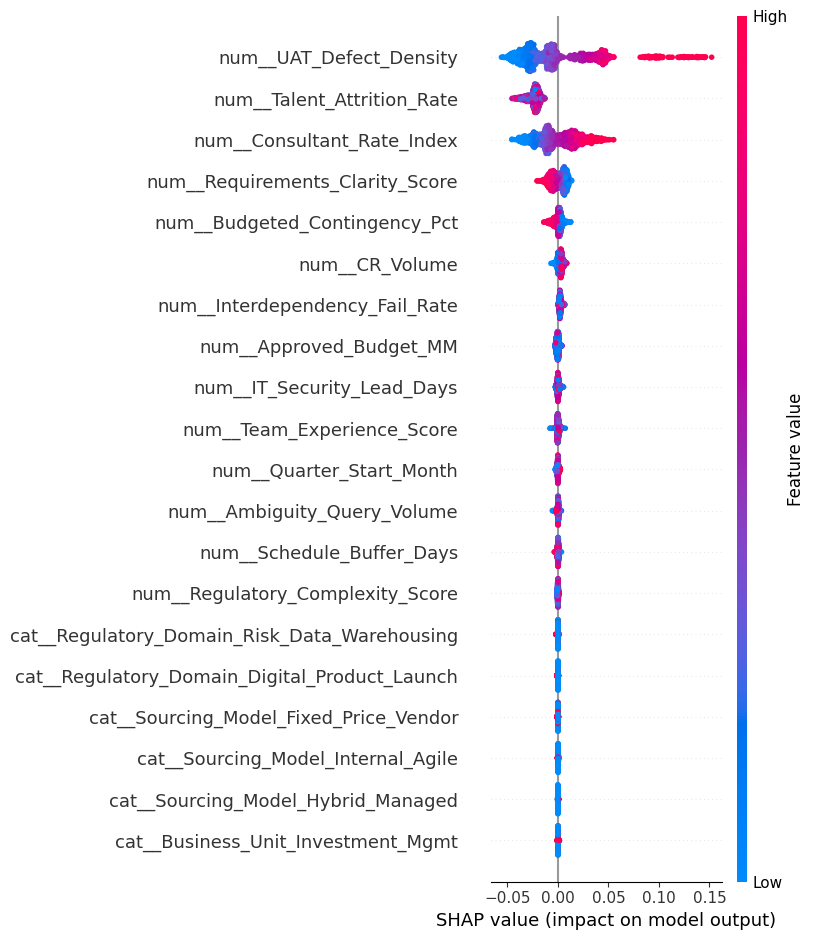

In [18]:
# pip install shap

import shap
m_cost = reg_cost.named_steps["model"]
X_trn_trans = pre.transform(X_train)
expl = shap.TreeExplainer(m_cost)
shap_values = expl.shap_values(X_trn_trans)
shap.summary_plot(shap_values, X_trn_trans, feature_names=pre.get_feature_names_out())

In [ ]:
# Each dot = one project (i.e., one major strategic transformation initiative).

# X-position (SHAP value) = that feature’s contribution to the prediction, pushing the forecast away from the average project prediction.

# Color = the raw feature value (red = high feature value, blue = low feature value).

# The horizontal spread shows the range of impact that feature can have on the model's output; thicker clouds often indicate more complex interactions.

# > 0 (to the right) pushes the prediction UP (your model predicts higher Budget Variance or Time-to-Market Delay).

# < 0 (to the left) pushes the prediction DOWN (your model predicts lower Budget Variance or Time-to-Market Delay).


# --- Interpretation of Key Adapted Drivers (Examples) ---

# num__UAT_Defect_Density — often the strongest driver. Higher UAT_Defect_Density (red) shifts predictions up (to the right), indicating higher Budget Variance (i.e., more unexpected rework costs).
# num__Consultant_Rate_Index — higher index value (red) pushes predictions up, signaling financial pressure from expensive external talent.
# num__Ambiguity_Query_Volume — a high volume of clarification queries pushes the prediction up, reflecting schedule risk from unclear business requirements.
# Categorical one-hot terms at the bottom (e.g., cat__Regulatory_Domain_*, cat__Sourcing_Model_*, cat__Business_Unit_*) have small average impact, meaning continuous factors are more influential than the project type itself.

In [19]:
# --- 2.6 Turn predictions into Strategic Reserves and Buffers ---

actions = alert_table.copy()

# 1. Calculate P80 Risk-Adjusted Budget Reserve (P80 Estimate)
# The base budget variance prediction is inflated based on the Go-Live Risk probability.
actions["p80_budget_reserve_pct"] = actions["pred_budget_variance_pct"] * (1 + 0.8 * actions["p_golive_risk"])

# 2. Recommended Cost Contingency (Financial Reserve)
# This converts the P80 estimate into an official reserve, clipped by a business rule (25% max).
actions["reco_contingency_pct"] = (actions["p80_budget_reserve_pct"] * 100).clip(0, 25).round(1)

# 3. Recommended Schedule Buffer (Time Reserve)
# The base delay prediction is inflated based on the Go-Live Risk probability, rounded up (np.ceil),
# and clipped by a business rule (60 days max).
actions["reco_buffer_days"] = np.ceil(
    actions["pred_time_to_market_delay_days"] * (1 + 0.5 * actions["p_golive_risk"])
).clip(0, 60).astype(int)

# 4. Display the Strategic Action Table (Top 10 High-Risk Projects)
actions[[
    "Approved_Budget_MM",
    "Regulatory_Domain",
    "Sourcing_Model",
    "p_golive_risk",
    "pred_budget_variance_pct",
    "pred_time_to_market_delay_days",
    "reco_contingency_pct",
    "reco_buffer_days"
]].head(10)

,Approved_Budget_MM,Regulatory_Domain,Sourcing_Model,p_golive_risk,pred_budget_variance_pct,pred_time_to_market_delay_days,reco_contingency_pct,reco_buffer_days
1916,17.884796,CoreSystem_Migration,Fixed_Price_Vendor,0.998333,0.187944,38.427645,25.0,58
1134,28.080130,Digital_Product_Launch,Time_and_Materials,0.998333,0.255696,30.250186,25.0,46
1350,25.716133,Risk_Data_Warehousing,Time_and_Materials,0.998333,0.183456,27.312160,25.0,41
1652,56.616302,CoreSystem_Migration,Hybrid_Managed,0.996667,0.252054,19.798981,25.0,30
1686,19.330493,Risk_Data_Warehousing,Hybrid_Managed,0.996667,0.214454,23.458714,25.0,36
730,51.821945,AML_Compliance,Fixed_Price_Vendor,0.996667,0.201118,22.393185,25.0,34
56,25.149996,CoreSystem_Migration,Internal_Agile,0.996667,0.187412,25.214949,25.0,38
1592,27.831328,CoreSystem_Migration,Internal_Agile,0.995000,0.294514,12.336595,25.0,19
1800,31.826323,Digital_Product_Launch,Hybrid_Managed,0.995000,0.202292,23.446778,25.0,36
1132,16.678948,AML_Compliance,Fixed_Price_Vendor,0.995000,0.189261,12.468921,25.0,19


In [20]:
# The analysis is telling us: “These **strategic transformation projects** (ranked by high p_golive_risk) look very risky, so the **financial reserve** is set at the max cap (25%) and a substantial schedule **Time-to-Market Buffer** (~+50% time reserve) is recommended.”

# The **25% budget contingency cap** is **clipping heavily** (all top-risk projects hit 25%). For better precision in **capital allocation**, the leadership team should consider: 
# 1. Raising the maximum cap (e.g., to 35%) for high-risk domains like Core System Migration. 
# 2. Making the cap **contextual** (tiered) based on the **Sourcing Model** (e.g., T&M projects get a higher cap than Fixed-Price) or the **Total Approved Budget (MM)**.

# **Strategic Action:** Tailor the reserve limits. For instance, **Regulatory Compliance** projects might require a higher schedule buffer cap due to fixed deadlines, while **Fixed-Price Vendor** projects might require a lower contingency cap due to lower internal financial risk exposure.

In [24]:
# Visual: Strategic Project Timeline with Predicted Time-to-Market Delay

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px

# --- sample slice (using adapted column names) ---
# Project grouping column is Regulatory_Domain, prediction is delay, risk is p_golive_risk
g = actions.head(6).copy()  # must contain: Regulatory_Domain, pred_time_to_market_delay_days, p_golive_risk

# planned dates (assuming a starting date for the visualization)
start0 = datetime(2025, 1, 6)
g["PlannedStart"]  = [start0 + timedelta(days=int(i*14)) for i in range(len(g))]
g["PlannedFinish"] = g["PlannedStart"] + pd.to_timedelta(np.random.randint(90, 210, len(g)), unit="D") # Random project duration 90-210 days

# predicted finish: planned finish + predicted delay (clipping negative slips to 0)
g["PredictedFinish"] = g["PlannedFinish"] + pd.to_timedelta(g["pred_time_to_market_delay_days"].clip(lower=0), unit="D")

# --- build the long dataframe ---
long = pd.concat([
    g.assign(Task="Planned").rename(columns={"PlannedStart":"Start","PlannedFinish":"Finish"})[
        ["Regulatory_Domain","Task","Start","Finish","p_golive_risk"] # Use adapted feature and risk name
    ],
    g.assign(Task="Predicted").rename(columns={"PlannedStart":"Start","PredictedFinish":"Finish"})[
        ["Regulatory_Domain","Task","Start","Finish","p_golive_risk"] # Use adapted feature and risk name
    ],
], ignore_index=True)

# ensure draw order: Predicted under, Planned on top
long["Task"] = pd.Categorical(long["Task"], categories=["Predicted","Planned"], ordered=True)

# Create the Timeline/Gantt Chart
fig = px.timeline(
    long.sort_values("Task"),
    x_start="Start", x_end="Finish",
    y="Regulatory_Domain", color="Task", # Use adapted feature name for Y-axis
    hover_data={"p_golive_risk":":.2f"}, # Use adapted risk name for hover data
    color_discrete_map={"Planned":"#1f77b4","Predicted":"#ff7f0e"}
)

# narrow bars and vertically offset within each y-category
fig.update_traces(width=0.4)
for tr in fig.data:
    if tr.name == "Planned":
        tr.update(offset=-0.22)  # top lane
    elif tr.name == "Predicted":
        tr.update(offset=+0.22)  # bottom lane

fig.update_yaxes(autorange="reversed")
fig.update_layout(title="Strategic Project Timeline: Planned vs Predicted Go-Live (by Regulatory Domain)", bargap=0.25, height=420)
# fig.show() # Use fig.show() in a notebook to display the interactive plot


# Note (Adapted for Finance/Strategic Transformation):
# The model anticipates Time-to-Market delays across every high-risk category.
# The degree of slippage visually represents the severity of the predicted delay. This allows the PMO to immediately compare the magnitude of time risk across different Regulatory Domain projects (e.g., Core System Migration vs. AML Compliance).